In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from loguru import logger

In [4]:
datapath = "data/data.csv"

# Load Data


> **Note**: It seems pandas couldn't read a large chunk of data. It's only able to load 6K data points.
I am sure I could have solved this, but the solution is just a crude way to approach the given problem for tagging a description. So, I let it be. (Plus, it was race against time)

### Important

If we're going to train a BERT-based Language Model, we will only use a subset of the data where
the length of the description < 512 (since BERT can only process 512 input tokens at a time).

> **NOTE**:
- This can be solved by treating classification of single data point as chunks where we could break the long text.
- Or, we can use other robust models like [Longformer](https://github.com/allenai/longformer) that can process 
at max 4096 input characters. 

In [5]:
def parse_kws(kw_str, level=2):
    res = kw_str.split(",")
    res = map(lambda kw: [_.strip().lower() for _ in kw.split(">")], res)
    res = map(lambda x: x[level if level<len(x) else len(x)-1], res)
    return list(set(res))

def load_data(path, level=0):
    logger.info(f"Loading data from {path}. [KW Level={level}]")
    df = pd.read_csv(path)
    df["desc"] = df["desc"].apply(str.strip)
    df["labels"] = df["keywords"].apply(lambda x: parse_kws(x, level))
    df["textlen"] = df["desc"].apply(len)
    return df

In [6]:
DATA = load_data(datapath, level=1)

2021-07-28 20:43:15.268 | INFO     | __main__:load_data:8 - Loading data from data/data.csv. [KW Level=1]


In [7]:
# Like I said, we're only able to load 6K data points which can be fixed in future!
DATA.shape

(5999, 4)

In [8]:
DATA.head()

,desc,keywords,labels,textlen
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[cryosphere, solid earth]",425
2,Digital line graph (DLG) data are digital repr...,EARTH SCIENCE > HUMAN DIMENSIONS > BOUNDARIES ...,"[terrestrial hydrosphere, human dimensions]",751
3,The 2000 Pilot Environmental Sustainability In...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, biosphere, land su...",956
4,The 2001 Environmental Sustainability Index (E...,EARTH SCIENCE > ATMOSPHERE > AIR QUALITY > EMI...,"[biological classification, biosphere, land su...",989


# Analysis

In [9]:
from collections import Counter, defaultdict

In [10]:
from loguru import logger

In [11]:
def analyze_labels(df):
    df = df.copy()
    labels = [l for ls in df["labels"] for l in ls]
    uniques = set(labels)
    logger.info(f"{len(uniques)} unique labels")

In [12]:
analyze_labels(DATA)

2021-07-28 20:43:17.303 | INFO     | __main__:analyze_labels:5 - 29 unique labels


### Text Length Analysis

In [13]:
_data = DATA.copy()
_data = _data[_data["textlen"]>0]
logger.debug(_data.shape)

# BERT can only process 512 sequence length at once
# So, what % of text satisfy that pre-condition?
len(_data[_data["textlen"] <= 512]) / len(_data), len(_data[_data["textlen"] <= 1024]) / len(_data)

2021-07-28 20:43:17.572 | DEBUG    | __main__:<module>:3 - (5999, 4)


(0.3295549258209702, 0.6309384897482914)

[(0.0, 3000.0)]

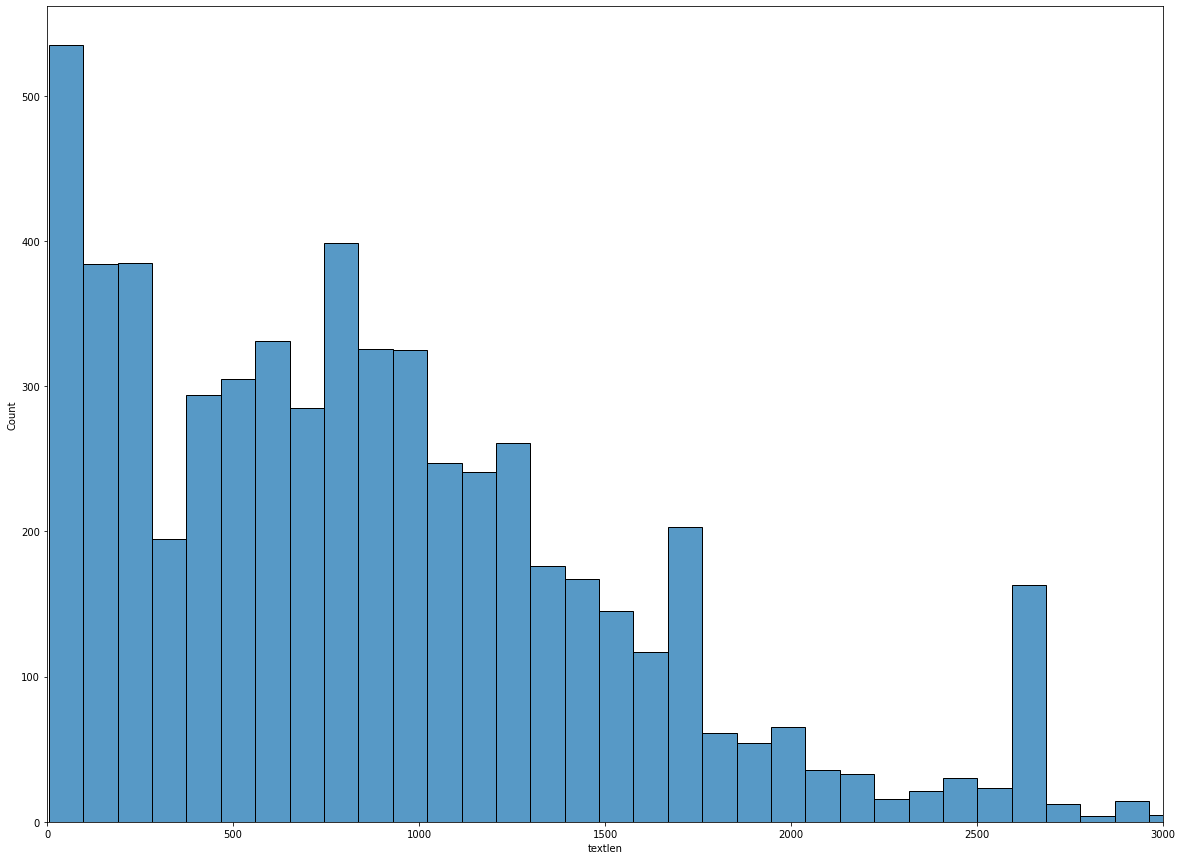

In [14]:
plt.figure(figsize=(20, 15))
sns.histplot(data=_data, x="textlen", bins=100).set(xlim=(0, 3000))

## MultiLabelEncoder Analysis

Since, the problem is a multi-label clasification (if we treat the problem as a classification problem), we need to see if we can encode the labels accordingly!

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
DATA_TO_USE = DATA.copy()
DATA_TO_USE = DATA_TO_USE[DATA_TO_USE["textlen"]<=500]
DATA_TO_USE.shape

In [ ]:
DATA_TO_USE.head()

In [ ]:
# Note: Now our level 1 keywords are <29 (N=22) classes because we have filtered the data 
analyze_labels(DATA_TO_USE)

In [19]:
LE = MultiLabelBinarizer()
LABELS_ENCODED = LE.fit_transform(DATA_TO_USE["labels"])

In [20]:
# 22 classes for level=1 keywords
LABELS_ENCODED.shape

(1930, 22)

In [21]:
LABELS_ENCODED[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [22]:
LE.classes_

array(['active remote sensing', 'agriculture', 'atmosphere',
       'biological classification', 'biosphere', 'climate indicators',
       'cryosphere', 'data analysis and visualization',
       'environmental advisories', 'human dimensions', 'hydrosphere',
       'land surface', 'nasa decadal survey', 'none', 'not provided',
       'oceans', 'paleoclimate', 'solid earth', 'spectral engineering',
       'spectral/engineering', 'sun-earth interactions',
       'terrestrial hydrosphere'], dtype=object)

In [23]:
# Test if inverse works
# Note: encoded lables should be 1s and 0s
LE.inverse_transform(LABELS_ENCODED[:10])

[('terrestrial hydrosphere',),
 ('cryosphere', 'solid earth'),
 ('atmosphere',),
 ('cryosphere', 'terrestrial hydrosphere'),
 ('biosphere', 'land surface'),
 ('biosphere', 'human dimensions'),
 ('atmosphere', 'biosphere', 'human dimensions', 'land surface'),
 ('atmosphere', 'sun-earth interactions'),
 ('atmosphere', 'sun-earth interactions'),
 ('cryosphere', 'land surface')]

In [24]:
DATA_TO_USE["labels_encoded"] = list(LABELS_ENCODED)

In [25]:
DATA_TO_USE.head()

,desc,keywords,labels,textlen,labels_encoded
0,USGS 15 minute stream flow data for Kings Cree...,EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURF...,[terrestrial hydrosphere],68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"This data set contains the VSMOW-SLAP d17O, d1...",EARTH SCIENCE > Solid Earth > Rocks/Minerals >...,"[solid earth, cryosphere]",425,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,30 minute rainfall data for the Konza Prairie,EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > P...,[atmosphere],45,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21,This data set provides glacier surface ablatio...,EARTH SCIENCE > Cryosphere > Glaciers/Ice Shee...,"[cryosphere, terrestrial hydrosphere]",367,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22,This data set provides a fire progression map ...,EARTH SCIENCE > BIOSPHERE > ECOLOGICAL DYNAMIC...,"[land surface, biosphere]",415,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


# Split Dataset

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
 X_train, X_test, Y_train, Y_test = train_test_split(DATA_TO_USE["desc"].to_numpy(), LABELS_ENCODED, test_size=0.1, random_state=42)

 X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [28]:
X_train.shape, X_val.shape, X_test.shape

((1563,), (174,), (193,))

In [29]:
Y_train.shape, Y_val.shape, Y_test.shape

((1563, 22), (174, 22), (193, 22))

# Create Pytorch Dataset

We are using pytorch lightning for the sake of convenience and easy prototyping

In [31]:
# ! pip install pytorch_lightning

In [32]:
import torch
from torch.utils.data import DataLoader, Dataset

In [40]:
import pytorch_lightning as pl

In [41]:
torch.__version__

'1.9.0+cpu'

In [42]:
torch.cuda.is_available()

False

In [61]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [43]:
class TagDataset (Dataset):
    """
        Holds the pytorch dataset
    """
    def __init__(self,texts, tags, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item_idx):
        text = self.texts[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [44]:
class TagDataModule (pl.LightningDataModule):
    
    def __init__(
        self,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        tokenizer,
        batch_size=4,
        max_token_len=512
    ):
        super().__init__()
        self.train_text = x_train
        self.train_label = y_train
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self):
        self.train_dataset = TagDataset(texts=self.train_text, tags=self.train_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = TagDataset(texts=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = TagDataset(texts=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset, batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset, batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset, batch_size= 16)

## Huggingface Transformers

Setup data and tokenizer

In [45]:
from transformers import AutoTokenizer, AutoModel

In [46]:
TOKENIZER = AutoTokenizer.from_pretrained("bert-base-uncased")
# BASE_MODEL = AutoModel.from_pretrained("bert-base-uncased")
BASE_MODEL = None

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [47]:
# Initialize the parameters that will be use for training
EPOCHS = 10
BATCH_SIZE = 4
MAX_LEN = 512
LR = 1e-03

In [48]:
TAG_DATA_MODULE = TagDataModule(
    X_train, Y_train,
    X_val, Y_val,
    X_test, Y_test,
    TOKENIZER,
    BATCH_SIZE,
    MAX_LEN
)
TAG_DATA_MODULE.setup()

## Setup Model

We're using bert-base-uncased and fine-tune it.

We're just replacing the output (classification) layer.

```
    ...
    ...
   (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (classifier): Linear(in_features=768, out_features=22, bias=True)
  (criterion): BCEWithLogitsLoss()
)
```

### Note
- We could in fact put a complex layer after BERT. But I have done it for the sake of simplicity.
- As mentioned earlier, we're only using level1 tags as it has the lowest number of classes for which
the problem could be solved as **classification problem**.

Also, we're using **BCEWithLogitsLoss** becauseo of **multi-label classification**. See: https://discuss.pytorch.org/t/using-bcewithlogisloss-for-multi-label-classification/67011/2

In [50]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [51]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [52]:
class TagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, base_model=None, n_classes=10, steps_per_epoch=None, n_epochs=5, lr=1e-5 ):
        super().__init__()

        self.model = base_model or AutoModel.from_pretrained("bert-base-uncased", return_dict=True)
        self.classifier = torch.nn.Linear(self.model.config.hidden_size,n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = torch.nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.model(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [53]:
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
MODEL = TagClassifier(BASE_MODEL, n_classes=22, steps_per_epoch=STEPS_PER_EPOCH,n_epochs=EPOCHS,lr=LR)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
# gpu
# trainer = pl.Trainer(max_epochs = EPOCHS , gpus = 1, callbacks=[], progress_bar_refresh_rate = 30)
trainer = pl.Trainer(max_epochs = EPOCHS, callbacks=[], progress_bar_refresh_rate = 30)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [55]:
trainer.fit(MODEL, TAG_DATA_MODULE)

/home/docuparadox/Nish/Programming/Python/projects/earth-science-text-classification/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name       | Type              | Params
-------------------------------------------------
0 | model      | BertModel         | 109 M 
1 | classifier | Linear            | 16.9 K
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.997   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/docuparadox/Nish/Programming/Python/projects/earth-science-text-classification/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


KeyboardInterrupt: 

In [56]:
# trainer.save_checkpoint("model-10.ckpt")

## Test

In [58]:
MODEL.eval()

TagClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [59]:
# trainer.test(MODEL,datamodule=TAG_DATA_MODULE)

## Inference

In [60]:
from torch.utils.data import TensorDataset, SequentialSampler

In [64]:
CONF_THRESH = 0.3

In [68]:
def inference(model, texts, tokenizer, batch_size=1):
    # model.eval()
    if isinstance(texts, str):
        texts = [texts]
    input_ids, attention_masks = [], []
    for text in texts:
        text_encoded = tokenizer.encode_plus(
                        text,
                        None,
                        add_special_tokens=True,
                        max_length= MAX_LEN,
                        padding = 'max_length',
                        return_token_type_ids= False,
                        return_attention_mask= True,
                        truncation=True,
                        return_tensors = 'pt'      
        )
        input_ids.append(text_encoded["input_ids"])
        attention_masks.append(text_encoded["attention_mask"])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    pred_data = TensorDataset(input_ids, attention_masks)
    pred_sampler = SequentialSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)
    pred_outs = []
    for batch in pred_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(DEVICE) for t in batch)
    
        # Unpack the inputs from our dataloader
        b_input_ids, b_attn_mask = batch
    
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            pred_out = model(b_input_ids,b_attn_mask)
            pred_out = torch.sigmoid(pred_out)
            # Move predicted output and labels to CPU
            pred_out = pred_out.detach().cpu().numpy()
        pred_outs.append(pred_out)
    return pred_outs

In [71]:
_texts = X_test[:5]
_pred_outs = inference(MODEL, _texts, TOKENIZER)

In [73]:
# If model is properly fine-tuned, this should be accurate
for _txt, _yt, _p in zip(_texts, Y_test, _pred_outs.copy()):
    _p = _p.flatten()
    confs = _p[_p>CONF_THRESH]
    _p[_p<CONF_THRESH] = 0
    _p[_p>=CONF_THRESH] = 1
    
    print(confs)
    pred_tag = LE.inverse_transform(np.array([_p]))[0]
    gt_tag = LE.inverse_transform(np.array([_yt]))[0]
    print(_txt[:50], gt_tag, pred_tag)

[0.45998588 0.4830769  0.39009407 0.5189705  0.4803717  0.50975114
 0.54787636 0.34423095 0.4665581  0.38090274 0.47248274 0.4457833
 0.44118464 0.63428545 0.48551884 0.51885164 0.46105388 0.43998215
 0.42852473 0.51147026 0.58508766]
Level 3, Seasonal climatology, ascending ancillary ('oceans',) ('active remote sensing', 'agriculture', 'atmosphere', 'biological classification', 'biosphere', 'climate indicators', 'cryosphere', 'data analysis and visualization', 'environmental advisories', 'human dimensions', 'hydrosphere', 'land surface', 'nasa decadal survey', 'none', 'not provided', 'oceans', 'solid earth', 'spectral engineering', 'spectral/engineering', 'sun-earth interactions', 'terrestrial hydrosphere')
[0.43458444 0.468253   0.37319997 0.50230104 0.4464024  0.5343185
 0.5744993  0.35050598 0.48038533 0.3767068  0.48330733 0.44385204
 0.43903014 0.6301987  0.49080366 0.5089056  0.472289   0.38934553
 0.45917654 0.49289444 0.6152085 ]
This data set consists of soil texture classifi

# Custom Evaluation

Since, it's a multi-label classification, find the actual "real" metric to evaluate is tricky.
Might depend on the usecase.

The train/val/test loss could also be a good indicator, but at the end, we need to infer
the actual labels and figure out if they are correct.

For that, I have used a jaccard similarity based metric, which is something similar to IoU for object detection, but for NLP. It's simply *how many of the labels are common* between two sets of labels (GT and PREDS)

In [16]:
import json

In [17]:
def inference2(model, tokenizer, texts, gts, threshold=0.3):
    _pred_outs = inference(model, texts, tokenizer, batch_size=1)
    res = []
    for txt, gt, pred in zip(texts, gts, _pred_outs):
        p = pred.flatten().copy()
        confs = p[p>threshold]
        p[p<threshold] = 0
        p[p>=threshold] = 1
        p = np.array([p])
        gt = np.array([gt])
        pred_tags = LE.inverse_transform(p)[0]
        gt_tags = LE.inverse_transform(gt)[0]
        res.append({"gts": gt_tags, "preds": pred_tags, "text": txt, "confs": list(confs)})
    return res

In [18]:
def compute_jaccard(tokens1, tokens2):
    if not tokens1 or not tokens2:
        return 0
    intersection = set(tokens1).intersection(tokens2)
    union = set(tokens1).union(tokens2)
    return len(intersection)/len(union)

In [19]:
compute_jaccard([1, 2], [1, 2, 3])

0.6666666666666666

In [78]:
def evaluate_jaccard(model, tokenizer, texts, gts, threshold=0.3):
    """
        Jaccard Evaluation. SIimlar to IoU
    """
    predictions = inference2(model, tokenizer, texts, gts, threshold)
    with open("inference.json", "w") as f:
        json.dump(predictions, f)
    metrics = []
    for pmap in predictions:
        metrics.append(compute_jaccard(pmap["gts"], pmap["preds"]))
    return metrics

In [83]:
_ = evaluate_jaccard(MODEL, TOKENIZER, X_test[:5], Y_test[:5], threshold=CONF_THRESH)

In [20]:
def eval_jaccard_json(jsonpath):
    """
        In case we have a json dump of the test inference
    """
    predictions = []
    with open(jsonpath) as f:
        predictions = json.load(f)
    metrics = []
    for pmap in predictions:
        gts = pmap["gts"]
        preds = pmap["preds"]
        sim = compute_jaccard(gts, preds)
        metrics.append((pmap["text"][:50], gts, preds, sim))
    return metrics

In [22]:
res = eval_jaccard_json("outputs/inference.json")

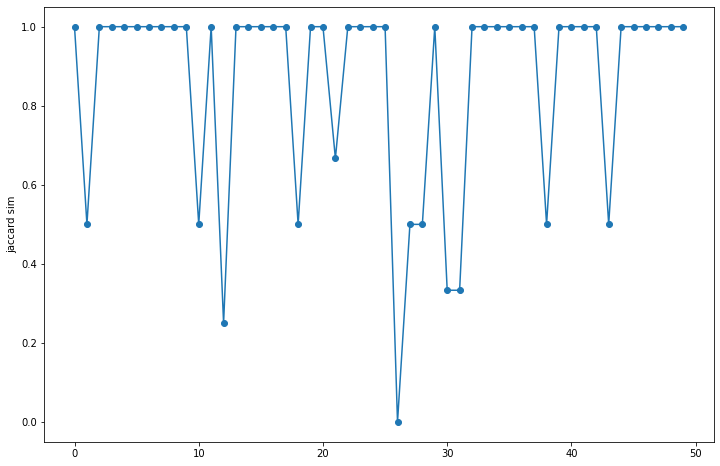

In [38]:
plt.figure(figsize=(12, 8))
sims = [r[-1] for r in res]
plt.scatter(range(len(sims)), sims)
plt.ylabel("jaccard sim")
plt.plot(sims)

# Further Improvement?

This was a very rough approach to the problem as **multi-label** classification.

## Approach 2 [Best One?]

However, we could also do some representation learning to embed each tags w.r.t text embedding from a LM.

I had done a very complex represntation problem 6months back, by implementing the following paper from Google:
[Representation Learning for Information Extraction from Form-like Documents](https://research.google/pubs/pub49122/)

## Approach 3

We could use [Longformer](https://github.com/allenai/longformer) that can have more sequence length.
(Or maybe other LMs)